# Early Data Analysis
Interpreting data from `batch_analyse.py`. The aim is to filter out the dataset to the required properties to explore potential exocomet-type transits.

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
import data
import os
from astropy.table import Table, unique
from analysis_tools_cython import *

---

### Functions

In [3]:
def get_output(file_path):
    """Imports batch_analyse output file as pandas dataframe."""
    with open(file_path) as f:
        lines = f.readlines()
    lc_lists = [word for line in lines for word in line.split()]
    lc_lists = [lc_lists[i:i+10] for i in range(0, len(lc_lists), 10)]
    cols = ['file','signal','signal/noise','time','asym_score','width1','width2','duration','depth','transit_prob']
    df = pd.DataFrame(data=lc_lists,columns=cols)
    df[cols[1:-1]] = df[cols[1:-1]].astype('float32')
    return df

def filter_df(df,min_asym_score=1.0,max_asym_score=2.0,duration=0.5,signal=-5.0):
    """filters df for given parameter range.
    Default settings:
    - `signal/noise` greater than 5.
        - Minimum test statistic is always negative. We flip the sign in plots for convenience.
    - `duration` set to greater than 0.5 days.
    - `asym_score` between 1.00 to 2.0.
    """
    return df[(df.duration >= duration) & (df['signal/noise'] <= signal) & (df['asym_score'] >= min_asym_score) & (df['asym_score'] <= max_asym_score)]

def distribution(x,y):
    """plots asymmetry score vs signal/noise over a signal of 5"""
    fig,ax = plt.subplots(figsize=(10,7))
    ax.scatter(x,y,s=1)
    ax.set_xlim(-1,1.9)
    ax.set_ylim(5,30)
    ax.set_xlabel('$\\alpha$')
    ax.set_ylabel('$S$')
    fig.tight_layout()


---

## Creating DataFrame
- data initially used is `corrected flux`, not PCA.

In [4]:
df = get_output('output_xrp_s6.txt')
filtered_df = filter_df(df)

In [5]:
df['transit_prob'].unique()

array(['maybeTransit', 'end', 'point', 'artefact'], dtype=object)

`filtered_df` with `maybeTransit` only

In [6]:
filtered_df[filtered_df.transit_prob == 'maybeTransit']

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
57,tesslc_300739338.pkl,-11.406204,-5.626895,1480.989746,1.105723,0.352566,0.029577,0.541675,-0.000620,maybeTransit
1140,tesslc_247714994.pkl,-14.944496,-5.909526,1473.412476,1.101007,0.025844,0.300981,0.562491,-0.001284,maybeTransit
1700,tesslc_290051280.pkl,-8.364285,-5.106937,1482.390381,1.007636,3.003695,0.001540,0.604163,-0.000477,maybeTransit
3272,tesslc_123407366.pkl,-6.855888,-5.166692,1476.057495,1.000150,0.363151,0.114332,0.937512,-0.001912,maybeTransit
3592,tesslc_155458657.pkl,-11.852999,-5.250652,1484.370850,1.029752,0.254848,0.038526,0.500006,-0.000733,maybeTransit
...,...,...,...,...,...,...,...,...,...,...
845366,tesslc_31144591.pkl,-7.159642,-5.817069,1476.201904,1.006671,0.618220,0.000340,0.916649,-0.006758,maybeTransit
845633,tesslc_270557338.pkl,-8.500902,-5.423230,1474.801392,1.058012,0.304159,0.000685,0.583337,-0.005133,maybeTransit
846594,tesslc_143376153.pkl,-4.324877,-5.151366,1485.431885,1.009443,0.244353,0.007590,0.520822,-0.002882,maybeTransit
846625,tesslc_287872763.pkl,-12.838039,-5.316705,1475.634766,1.028915,0.516079,0.020085,0.645845,-0.012351,maybeTransit


---

### Raw Plot - sample size 846k

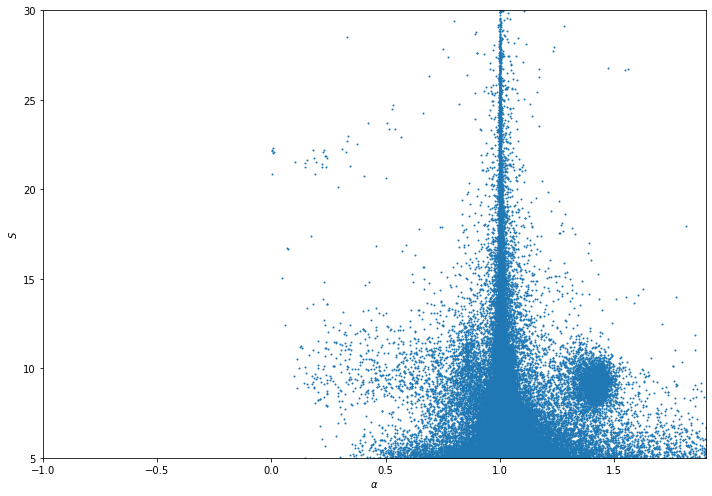

In [7]:
distribution(df.asym_score,abs(df['signal/noise']))

### `MaybeTransit` only - sample size 846k

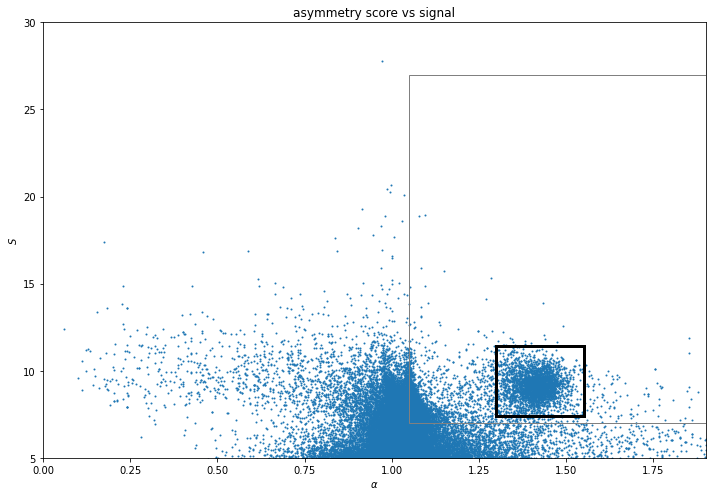

In [8]:
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(df.asym_score[df.transit_prob == 'maybeTransit'],abs(df['signal/noise'][df.transit_prob == 'maybeTransit']),s=1)
ax.set_xlim(0,1.9)
ax.set_ylim(5,30)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$S$')
ax.set_title('asymmetry score vs signal')
fig.tight_layout()
rect = patches.Rectangle((1.30, 7.40), 0.25, 4, linewidth=3, edgecolor='k', facecolor='none')
interest_region = patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none') # region of interest in Kennedy et al
ax.add_patch(rect)
ax.add_patch(interest_region)
plt.show()

Next steps - apply a feature that distinguishes false positives, EB's, etc.

---

### Exploring that black boxed region (S6)

Create our box with the following settings:
- `signal/noise` between 7.4 and 12
- `asym_score` between 1.3 and 1.6

In [9]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]

In [10]:
to_import = box['file'].tail(20)

---

In [11]:
sector = 6
path = '/storage/astro2/phrdhx/tesslcs'
mad_df = data.load_mad()

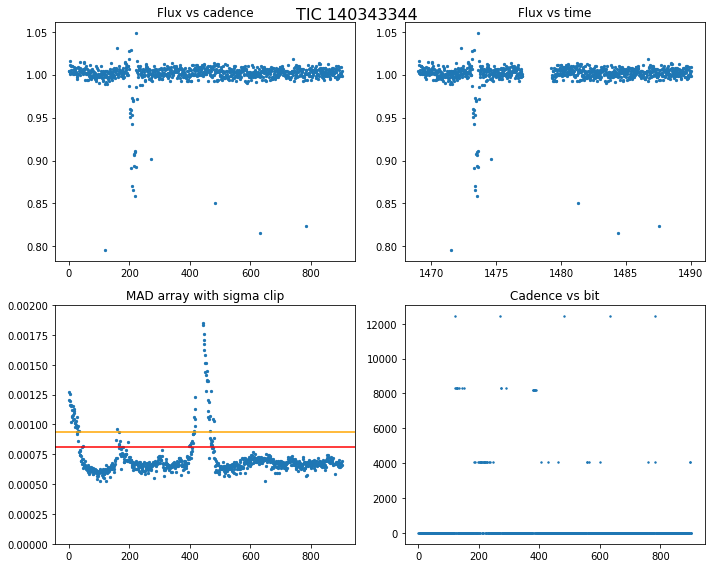

In [12]:
tic_id = []
for i in to_import:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=False)[0] # drop_bad_points is True
    store = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=False)[1]
    cam = store[4]
    mad_arr = mad_df.loc[:len(table)-1, f"{sector}-{cam}"]
    sig_clip = sigma_clip(mad_arr,sigma=4,masked=True)
    mad_cut = mad_arr.values < ~sig_clip.mask 
    fig,ax = plt.subplots(2,2,figsize=(10,8))
    TIC_ID = file_paths.split('_')[-1][:-4]
    tic_id.append(file_paths.split('_')[-1][:-4])
    fig.suptitle(f'TIC {TIC_ID}',fontsize=16)
    ax[0,1].scatter(table['time'],normalise_lc(table['corrected flux']),s=5)
    ax[0,1].set_title('Flux vs time')
    ax[0,0].scatter(range(0,len(table['time'])),normalise_lc(table['corrected flux']),s=5)
    ax[0,0].set_title('Flux vs cadence')
    ax[1,0].scatter(range(0,len(table['time'])), mad_arr, s=5)
    ax[1,0].axhline(np.nanmedian(sig_clip.data) + 4*np.nanstd(sig_clip), c='orange',label='experiment MAD')
    ax[1,0].axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='red',label='visualised MAD')
    ax[1,0].set_ylim([0.000,0.002])
    ax[1,0].set_title('MAD array with sigma clip')
    ax[1,1].scatter(range(0,len(table['time'])),table['quality'],s=2)
    ax[1,1].set_title('Cadence vs bit')
    fig.tight_layout()
                  
    plt.show()
    break
    #plt.savefig(f'figs_tess/output_analysis/lightcurve {lc_info[0]} at import')

### Comparing this with eleanor lightcurve

In [13]:
import eleanor

INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-1-4-cal-0510-1834_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-1-4-cal-0510-1834_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-1-4-cal-0510-1834_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-1-4-cal-0510-1834_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-1-4-cal-0510-1834_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-1-4_tess_v2_pm.txt with expected size 184377. [astroquery.query]


(0.9, 1.1)

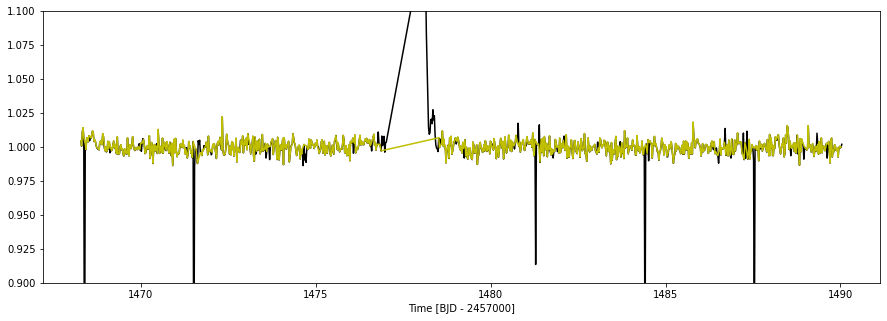

In [14]:
star = eleanor.Source(tic=140343344, sector=6)
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=False, do_pca=True, regressors='corner')
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time, data.corr_flux/np.nanmedian(data.corr_flux), 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]), 'y')
#plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.ylim([0.9,1.1])

---

### Trying one lightcurve import manually

In [15]:
test = pd.read_pickle('/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/tesslcs_tmag_14_15/tesslc_140343344.pkl')

In [16]:
test_lc = test[6:]

In [17]:
columns = [
        "time",
        "raw flux",
        "corrected flux",
        "PCA flux",
        "flux error",
        "quality",
    ]
test_lc = pd.DataFrame(data=test_lc).T 
test_lc.columns = columns

In [18]:
q = test_lc.quality == 0

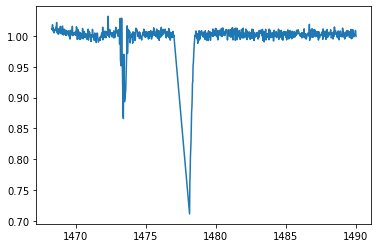

In [19]:
plt.plot(test_lc.time[q],normalise_lc(test_lc['corrected flux'][q]))
plt.show()